In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Загрузим данные train.csv и создадим датафрейм df

In [5]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './data_prepared.csv'

df = pd.read_csv(DATASET_PATH, sep=',')
df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


Поработаем с типом данных и изменим размерность

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Уменьшаем размерность

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
df.dtypes.count()

20

Выйграли 68,1% памяти. Прекрасно!

## 1. Переходим к анализу EDA и сразу будем абрабатывать аномальные значения

## 1.1 Проведем анализ целевой переменной

In [11]:
target = 'Price'

In [12]:
target_mean = round(df[target].mean(), 2)
target_median = df[target].median()
target_mode = df[target].mode()[0]

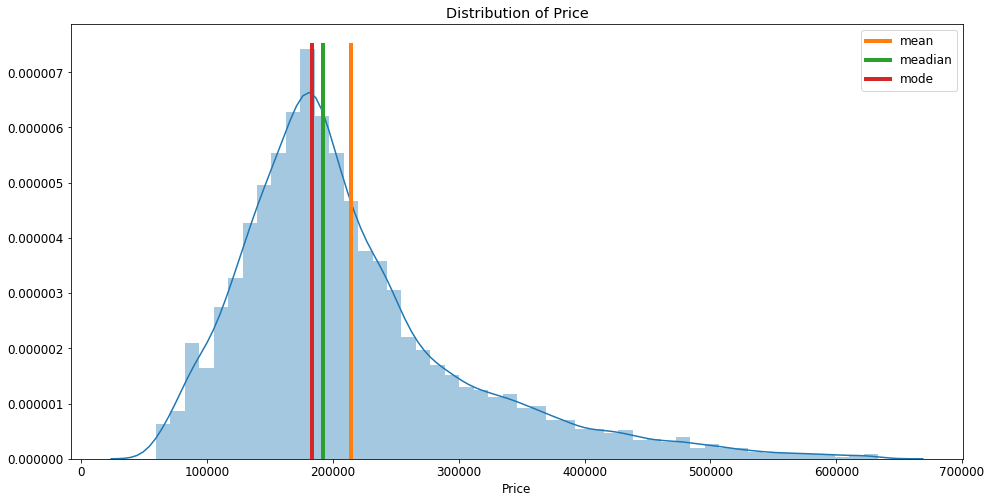

In [13]:
plt.figure(figsize = (16, 8))

sns.distplot(df[target], bins=50)

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='meadian',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Хорошее и логичное распредление. Нет выбросов. Меры центральной тенденции смещены влево, что может свидетельствовать о том, что количество дорогих домов превалирует над дешевыми. Гипотеза: модель, обученная на этих данных будет хуже предстказывать стоимость более дешевых домой.

## 1.2 Количественные переменные

In [14]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [15]:
df_num_features = df.select_dtypes(include=['int16', 'float32', 'int8', 'int32'])
df_num_features.drop([target], axis=1, inplace=True)

In [16]:
df_num_features.dtypes

Id                 int16
DistrictId         int16
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
dtype: object

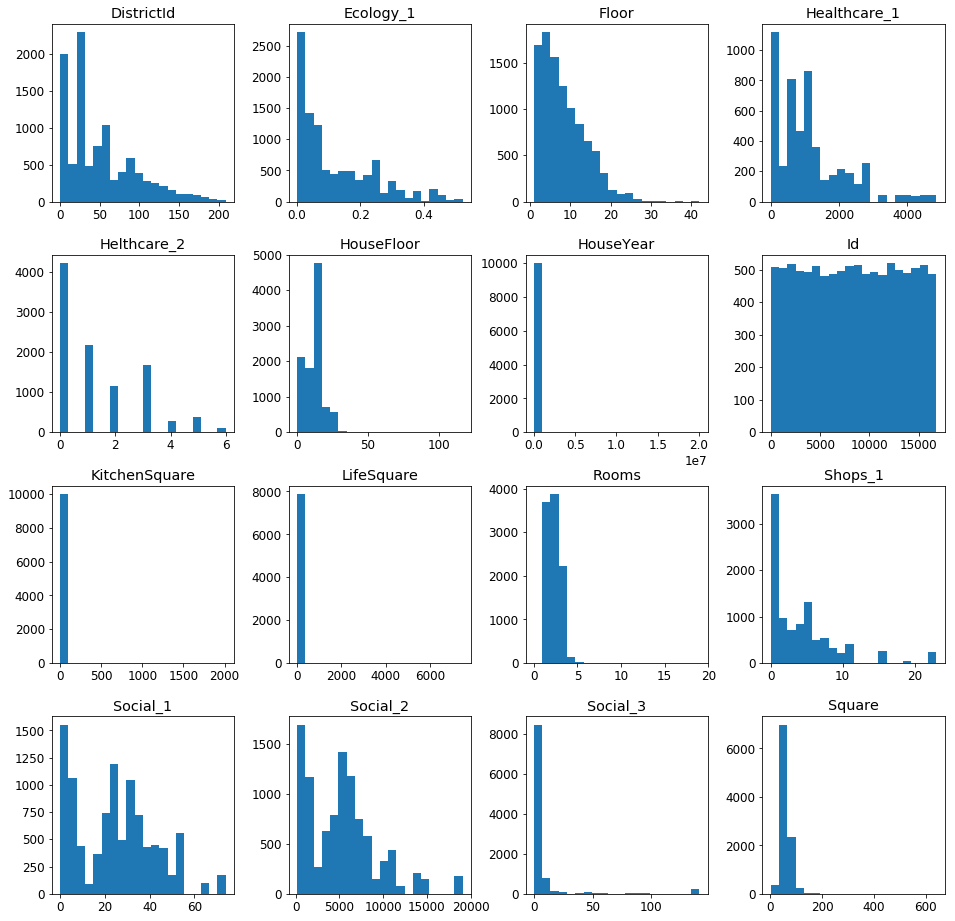

In [17]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Проверим Rooms

In [18]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Будем считать аномальными результатами количество комнат равное 0, и больше 6

In [19]:
df['Rooms_outlier'] = 0
df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 6), 'Rooms_outlier'] = 1
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] > 6, 'Rooms'] = df['Rooms'].median()

In [20]:
df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

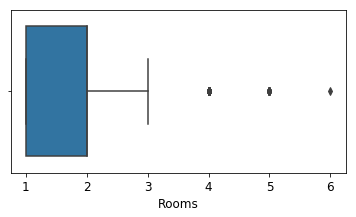

In [21]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

График рисует наличие выбросов справа. Это не выбросы - скорее уникальные квартиры.

Проверим LifeSquare

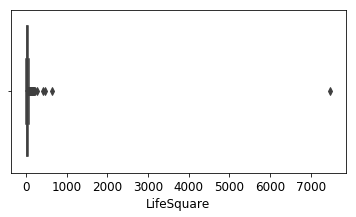

In [22]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [23]:
df.loc[df['LifeSquare'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
357,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,...,B,6,1437,3,NaN,0,2,B,141780.234375,0
1776,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,394253.312500,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
7644,7917,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
8000,16550,27,3.0,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,...,B,2,469,0,NaN,0,0,B,217357.500000,0
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.687500,0


В данном случае это точно выброс. Жилая площадь не может быть больше Площади общей. Вероятно тут опечатки и уменьшение жилой площади в 100 раз смотрится уже более адекватно.

In [24]:
df.loc[(df['LifeSquare'] > 150) & (df['Rooms'] < 4)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
357,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,...,B,6,1437,3,NaN,0,2,B,141780.234375,0
730,14181,62,3.0,156.636581,153.685837,1.0,1,3.0,2005,0.072158,...,B,2,629,1,NaN,0,0,A,502523.562500,0
3204,5621,23,3.0,163.495331,161.504227,12.0,5,3.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,207007.953125,0
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,394253.312500,0
5283,11055,151,1.0,174.649521,174.837082,15.0,10,12.0,1958,0.236108,...,B,16,3893,27,NaN,3,10,B,232766.187500,0
5712,8961,27,1.0,33.398983,164.153366,6.0,3,5.0,1965,0.211401,...,B,9,1892,0,NaN,0,1,B,104891.070312,0
6030,15362,23,1.0,163.286972,161.155273,1.0,4,3.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,228572.515625,0
6450,2603,30,3.0,162.587891,164.526764,0.0,2,3.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,207407.359375,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
7644,7917,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1


Эти данные так же выглядят аномально, поэтому их уменьшим в 10 раз

Проверим Square

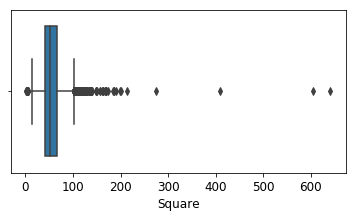

In [25]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [26]:
df.loc[df['Square'] > 150]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
403,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,...,B,74,19083,2,NaN,5,15,B,622888.812500,0
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,...,B,25,5648,1,30.0,2,4,B,187717.250000,0
730,14181,62,3.0,156.636581,153.685837,1.0,1,3.0,2005,0.072158,...,B,2,629,1,NaN,0,0,A,502523.562500,0
1449,11764,93,3.0,169.117203,NaN,1.0,5,3.0,1977,0.004949,...,B,0,186,0,NaN,0,0,B,211325.578125,0
1606,3718,56,3.0,190.857681,107.376167,19.0,7,3.0,2007,0.000000,...,B,23,5067,4,NaN,2,6,B,338644.062500,0
1776,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
2066,14556,183,4.0,151.150665,98.187485,23.0,6,7.0,1912,0.037316,...,B,32,6748,93,562.0,4,10,B,284884.968750,0
2790,15947,129,4.0,185.906403,84.830078,31.0,5,3.0,2015,0.020741,...,B,24,5613,5,1340.0,2,5,B,340273.250000,0
3182,3914,24,4.0,155.930023,76.831291,15.0,6,22.0,2012,0.111627,...,B,50,12238,8,1970.0,2,3,B,559886.937500,0


Если посмотреть на цену и плозадь квартир. Складывается впечатление, что квадратура должна быть в 10 раз меньше. Но, в данной выборке есть 4х комнатные квариры, площадь которых вполне может быть огромной. Уточним выборку

In [27]:
df.loc[(df['Square'] > 150) & (df['Rooms'] < 4)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,...,B,25,5648,1,30.0,2,4,B,187717.250000,0
730,14181,62,3.0,156.636581,153.685837,1.0,1,3.0,2005,0.072158,...,B,2,629,1,NaN,0,0,A,502523.562500,0
1449,11764,93,3.0,169.117203,NaN,1.0,5,3.0,1977,0.004949,...,B,0,186,0,NaN,0,0,B,211325.578125,0
1606,3718,56,3.0,190.857681,107.376167,19.0,7,3.0,2007,0.000000,...,B,23,5067,4,NaN,2,6,B,338644.062500,0
3204,5621,23,3.0,163.495331,161.504227,12.0,5,3.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,207007.953125,0
4444,5602,93,3.0,169.385178,NaN,1.0,2,10.0,1977,0.004949,...,B,0,186,0,NaN,0,0,B,190949.296875,0
5283,11055,151,1.0,174.649521,174.837082,15.0,10,12.0,1958,0.236108,...,B,16,3893,27,NaN,3,10,B,232766.187500,0
5764,6674,54,1.0,168.086349,125.486565,30.0,18,28.0,2011,0.006076,...,B,30,5285,0,645.0,6,6,B,367353.562500,0
5844,4991,93,3.0,167.767029,NaN,1.0,1,1.0,1977,0.004949,...,B,0,186,0,NaN,0,0,B,211180.796875,0
6030,15362,23,1.0,163.286972,161.155273,1.0,4,3.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,228572.515625,0


Вот эти данные можно уменьшить в 10 раз

In [28]:
df.loc[df['Square'] < df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
33,847,74,2.0,73.314972,74.131264,1.0,7,6.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,254005.375000,0
64,3992,1,3.0,87.200623,87.730225,0.0,21,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,300180.375000,0
77,11771,45,1.0,38.467278,39.624493,1.0,11,9.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,247440.531250,0
100,13343,74,2.0,79.937668,82.931595,1.0,8,21.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,226808.750000,0
111,13875,20,1.0,28.438793,32.514023,6.0,6,10.0,2014,0.019509,...,B,37,7687,11,176.0,5,5,B,199248.109375,0
142,5402,27,4.0,98.649406,100.855911,1.0,3,1.0,2019,0.072158,...,B,2,629,1,NaN,0,0,A,294689.625000,0
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.187500,0
165,10005,58,1.0,44.995129,47.483234,0.0,3,2.0,2019,0.437885,...,B,23,5735,3,1084.0,0,5,B,106866.250000,0
179,8974,54,2.0,90.144104,91.796524,1.0,10,9.0,2017,0.006076,...,B,30,5285,0,645.0,6,6,B,502813.781250,0
213,16266,6,2.0,61.735729,62.898666,0.0,16,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,168514.437500,0


Складыавется впечателение, что значения просто поменяны местами. Собственно в обработке это и сделаем.

Проверим KitchenSquare

In [29]:
df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

Аномальными кажутся большие значения кухонь, обработаем их черех квантили

In [30]:
condition = (df['KitchenSquare'].isna()) | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.975))
        
df.loc[condition, 'KitchenSquare'] = df['KitchenSquare'].median()

df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [31]:
df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [32]:
(df['KitchenSquare'] > df['Square']).sum()

5

In [33]:
df.loc[df['KitchenSquare'] > df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
161,6782,45,1.0,2.954309,5.257278,3.0,3,1.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.187500,0
4496,15744,34,1.0,1.988943,2.642219,3.0,21,4.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,458378.781250,0
7470,14786,1,1.0,1.136859,4.525736,3.0,3,1.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,181434.828125,0
8572,10202,6,1.0,2.596351,4.604943,3.0,3,25.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,137597.593750,0
9869,3224,27,1.0,2.377248,0.873147,3.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,1


Площадь кухни не может быть больше площади квартиры. В выбранных данных 1 комната и вероятно это студия. Вероятно кухню и илую комнату реазделить невозможно Приравние в данной ситуации кажется наиболее вероятным и логичным

In [34]:
df.loc[df['KitchenSquare'] > df['Square'], 'KitchenSquare'] = df[df['KitchenSquare'] > df['Square']].median()

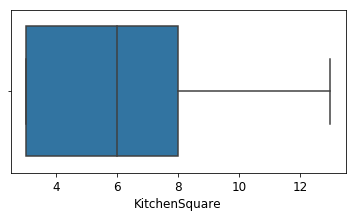

In [35]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

Преобладают маленькие кухни и это кажется вполне нормальным

Проверим LifeSquare

In [36]:
df['LifeSquare'].value_counts()

33.859653     2
35.999996     1
23.169222     1
46.338703     1
19.669596     1
46.339333     1
19.669765     1
27.669773     1
24.098726     1
21.169897     1
46.339981     1
46.340332     1
35.340485     1
79.337334     1
47.453102     1
47.340717     1
18.125830     1
48.341309     1
33.341412     1
19.251589     1
34.341587     1
25.230425     1
22.670929     1
40.342342     1
42.342392     1
20.671246     1
48.317085     1
117.446938    1
21.671370     1
23.669313     1
             ..
31.837019     1
31.836998     1
24.836065     1
54.670780     1
33.512142     1
31.335464     1
60.238789     1
4.083905      1
60.671326     1
54.671585     1
34.671696     1
32.671753     1
29.335958     1
47.671970     1
11.168019     1
28.033890     1
30.836899     1
30.336201     1
51.672474     1
67.345085     1
15.418166     1
42.672680     1
61.673016     1
22.836563     1
24.836664     1
45.673462     1
18.836775     1
67.347176     1
62.673653     1
37.604706     1
Name: LifeSquare, Length

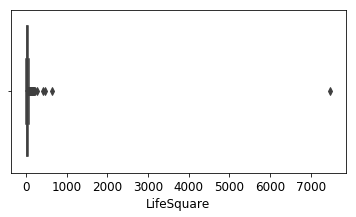

In [37]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [38]:
df.loc[df['LifeSquare'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
357,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,...,B,6,1437,3,NaN,0,2,B,141780.234375,0
1776,16568,27,4.0,200.334534,201.627365,6.0,1,2.0,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0
1906,5548,86,5.0,275.645294,233.949310,6.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,394253.312500,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
7644,7917,27,1.0,212.932358,211.231125,3.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
8000,16550,27,3.0,81.694420,7480.592285,3.0,9,17.0,2016,0.017647,...,B,2,469,0,NaN,0,0,B,217357.500000,0
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.687500,0


Да, данные смотрятся очень огромными. Я бы предполодила, что тут квартиры площадью 41 и 64 соответсвенно.

In [39]:
vrem = df.loc[df['LifeSquare'] > 300, ['Square', 'LifeSquare']]
vrem

,Square,LifeSquare
5183,78.059334,461.463623
7010,409.425171,410.639740
8000,81.694420,7480.592285
9229,641.065186,638.163208


In [40]:
vrem = vrem / 10
vrem

,Square,LifeSquare
5183,7.805933,46.146362
7010,40.942516,41.063972
8000,8.169442,748.059204
9229,64.106522,63.816322


In [41]:
df.loc[df['LifeSquare'] > 300, ['Square', 'LifeSquare']] = vrem

In [42]:
df.loc[df['Id'] == 11602, ['Square', 'LifeSquare']]

,Square,LifeSquare
9229,64.106522,63.816322


Проверим HouseFloor и Floor

In [43]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

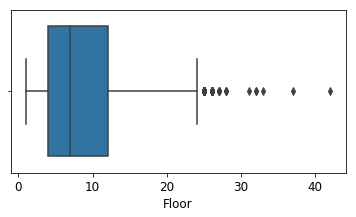

In [44]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Floor'], whis=1.5)

plt.xlabel('Floor')
plt.show()

Тут все смотрится волне логично, но вот есть данные которые не бьются с этажностью дома

In [45]:
df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

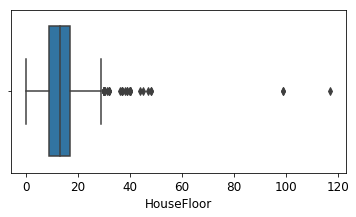

In [46]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

In [47]:
df.loc[(df['HouseFloor'] > 90)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
746,9300,74,2.0,71.747871,74.579811,9.0,5,99.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,243329.90625,0
1678,78,30,2.0,65.773750,66.811790,3.0,8,117.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,207248.37500,0
4657,10806,5,1.0,51.944588,48.709602,3.0,6,99.0,1977,0.150818,...,B,16,3433,4,2643.0,4,5,B,296127.12500,0


Этажность дома более 90 этажей кажется весьма маловероятной. Стоит заменить.

In [48]:
(df['HouseFloor'] == 0).sum()

269

Количество этажей в доме равно 0, выглядит как ошибка. Стоит заменить.

In [49]:
(df['Floor'] > df['HouseFloor']).sum()

1825

Эти данные тоже отработаем

In [50]:
df['HouseFloor_outlier'] = 0
df.loc[df['HouseFloor'] > 90, 'HouseFloor_outlier'] = 1
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

In [51]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
df.loc[df['HouseFloor'] > 90, 'HouseFloor'] = df['HouseFloor'].median()

In [52]:
floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [53]:
df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

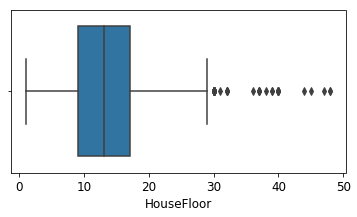

In [54]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

Данные выглядят уже более презентабельно и логично

Проверим HouseYear

In [55]:
df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
3171        2020
3196        2020
7955        2020
9091        2020
9122        2020
7721        2020
1976        2020
6073        2020
5641        2020
5412        2020
8664        2020
7302        2020
9400        2020
1077        2020
7207        2020
1004        2020
727         2019
6358        2019
7917        2019
7923        2019
5863        2019
7973        2019
9026        2019
7397        2019
4851        2019
          ...   
3758        1932
9854        1931
1761        1931
6080        1931
2120        1931
2844        1931
7106        1931
5520        1931
2255        1930
9517        1930
7005        1930
2816        1929
3981        1929
6442        1928
7380        1919
6235        1919
2187        1919
7868        1918
3026        1918
3470        1918
2093        1918
9927        1918
1572        1917
485         1917
7867        1917
7610        1916
6250        1914
2066        19

In [56]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

## 1.3 Нормативные переменные

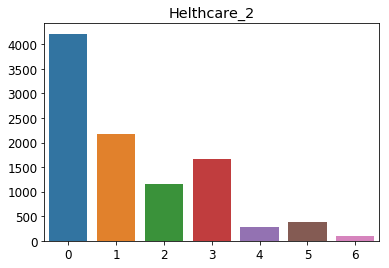

In [57]:
counts = df['Helthcare_2'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Helthcare_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

Все ок, без выбросов

In [58]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
62     247
30     228
58     179
53     174
21     165
52     143
8      142
11     129
46     119
61     118
45     116
74     114
34     111
57     107
44     104
99      97
101     97
47      97
13      97
7       92
48      90
29      89
94      89
41      87
3       82
      ... 
133      5
166      5
189      5
65       5
188      5
82       5
112      4
136      4
179      4
50       4
182      4
180      4
185      3
193      3
201      3
175      3
181      3
208      2
158      2
172      2
195      2
202      2
186      2
196      1
117      1
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В принципе ок, на этапе работы с новыми признаками - придумаем как быть с районами

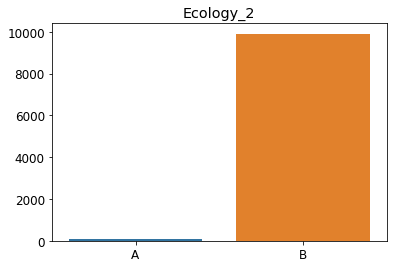

In [59]:
counts = df['Ecology_2'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

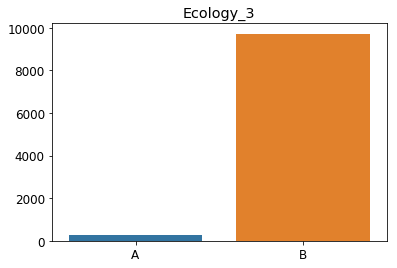

In [60]:
counts = df['Ecology_3'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
    
plt.show()

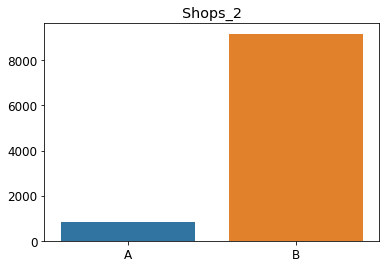

In [61]:
counts = df['Shops_2'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

Все ок, перекодировкой займемся при построении новых признаков

# 2. Пропуски

In [62]:
df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            5
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [63]:
df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1

condition = (df['LifeSquare'].isna()) \
             & (~df['Square'].isna()) \
             & (~df['KitchenSquare'].isna())
        
df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] \
                                            - df.loc[condition, 'KitchenSquare'] - 3

In [64]:
df.drop('Healthcare_1', axis=1, inplace=True)

In [65]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.life_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.life_square_quantile = X['LifeSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1   
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # LifeSquare
        cond = X['LifeSquare'] > 1000
        X.loc[cond, 'LifeSquare'] = X.loc[cond, 'LifeSquare'].apply(lambda x: x/100)
        cond = (X['LifeSquare'] > 150) & (X['Rooms'] < 4)
        X.loc[cond, 'LifeSquare'] = X.loc[cond, 'LifeSquare'].apply(lambda x: x/10)
        
        
        # Square
        vrem = X.loc[(X['Square'] - X['LifeSquare'] < 0), ['Id', 'Square', 'LifeSquare']]
        X.loc[(X['Square'] - X['LifeSquare'] < 0), 'Square'] = vrem ['LifeSquare']
        X.loc[(X['Square'] == X['LifeSquare']), 'LifeSquare'] = vrem ['Square']        

        cond = (X['Square'] > 150) & (X['Rooms'] < 4)
        X.loc[cond, 'Square'] = X.loc[cond, 'Square'].apply(lambda x: x/10)
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = 2020
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# 3.Построение новых признаков

Переодируем переменные с категориями A и B в бинарные признаки

In [66]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

Преобразуем переменную DistrictId. Почсчитаем количество объектов в районе и сделаем это еще одной переменной.

In [67]:
district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [68]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.875000,0,0,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.546875,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.718750,0,0,0,652
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.000000,0,0,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.093750,0,0,0,89


Посчитаем стоимость квартир (медиану) в зависимости от района и уровню предоставления медицинских услуг

In [69]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [70]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,0,1,305018.875000,0,0,1,851,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,1,0,1,177734.546875,0,0,0,78,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,3,1,1,282078.718750,0,0,0,652,244005.281250
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,0,1,1,168106.000000,0,0,1,652,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,2,0,6,1,343995.093750,0,0,0,89,201584.437500


Посчитаем стоимость квартир (медиану) в зависимости от этажности, года постройки

In [71]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [72]:
bins = [0, 3, 5, 9, 15, df['Floor'].max()]
pd.cut(df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
5       2
6       0
7       2
8       3
9       0
10      1
11      0
12      2
13      1
14      0
15      0
16      2
17      0
18      4
19      3
20      2
21      1
22      0
23      2
24      0
25      0
26      0
27      3
28      1
29      0
       ..
9970    2
9971    3
9972    1
9973    1
9974    0
9975    0
9976    3
9977    3
9978    3
9979    0
9980    2
9981    1
9982    2
9983    1
9984    3
9985    2
9986    0
9987    4
9988    2
9989    2
9990    0
9991    2
9992    1
9993    1
9994    3
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [73]:
bins = [0, 3, 5, 9, 15, df['Floor'].max()]
pd.cut(df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
5         (5, 9]
6         (0, 3]
7         (5, 9]
8        (9, 15]
9         (0, 3]
10        (3, 5]
11        (0, 3]
12        (5, 9]
13        (3, 5]
14        (0, 3]
15        (0, 3]
16        (5, 9]
17        (0, 3]
18      (15, 42]
19       (9, 15]
20        (5, 9]
21        (3, 5]
22        (0, 3]
23        (5, 9]
24        (0, 3]
25        (0, 3]
26        (0, 3]
27       (9, 15]
28        (3, 5]
29        (0, 3]
          ...   
9970      (5, 9]
9971     (9, 15]
9972      (3, 5]
9973      (3, 5]
9974      (0, 3]
9975      (0, 3]
9976     (9, 15]
9977     (9, 15]
9978     (9, 15]
9979      (0, 3]
9980      (5, 9]
9981      (3, 5]
9982      (5, 9]
9983      (3, 5]
9984     (9, 15]
9985      (5, 9]
9986      (0, 3]
9987    (15, 42]
9988      (5, 9]
9989      (5, 9]
9990      (0, 3]
9991      (5, 9]
9992      (3, 5]
9993      (3, 5]
9994     (9, 15]
9995      (0, 3]
9996     (9, 15]
9997      (0, 

In [74]:
df = year_to_cat(df)
df = floor_to_cat(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,1,305018.875000,0,0,1,851,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,1,177734.546875,0,0,0,78,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,1,282078.718750,0,0,0,652,244005.281250,4,1
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,1,168106.000000,0,0,1,652,146735.671875,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,6,1,343995.093750,0,0,0,89,201584.437500,3,5


In [75]:
med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,368718.25000
1,1,2,321497.43750
2,1,3,429458.37500
3,1,4,274992.46875
4,2,1,467230.53125


In [76]:
df = df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,0,1,851,213530.781250,6,2,165636.156250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,0,78,146032.828125,3,3,192711.531250
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,0,652,244005.281250,4,1,207856.718750
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,168106.000000,0,0,1,652,146735.671875,3,4,183469.921875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,343995.093750,0,0,0,89,201584.437500,3,5,173955.562500


Создадим новый признак стоимость 1 кв.м в заисимости от района

In [77]:
df['SquarePrice'] = df['Price'] / df['Square']
df['SquarePrice'].head()

0    2651.708252
1    4462.045898
2    3600.596680
3    4160.019531
4    5351.088867
Name: SquarePrice, dtype: float32

In [78]:
price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'SquarePrice':'median'}).rename(columns={'SquarePrice':'PriceByDistrict'})

price_by_district.count()

DistrictId         205
PriceByDistrict    205
dtype: int64

In [79]:
df = df.merge(price_by_district, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,SquarePrice,PriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,851,213530.781250,6,2,165636.156250,2651.708252,2761.685303
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,78,146032.828125,3,3,192711.531250,4462.045898,3553.678467
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,652,244005.281250,4,1,207856.718750,3600.596680,3251.647461
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,0,1,652,146735.671875,3,4,183469.921875,4160.019531,3251.647461
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,89,201584.437500,3,5,173955.562500,5351.088867,4219.992676


In [80]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.price_by_district = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['SquarePrice'] = df['Price'] / df['Square']
            self.price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'SquarePrice':'median'})\
                                            .rename(columns={'SquarePrice':'PriceByDistrict'})
            
            self.price_by_district_median = self.price_by_district['PriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
            
        if self.price_by_district is not None:
            X = X.merge(self.price_by_district, on=['DistrictId'], how='left')
            X.fillna(self.price_by_district_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    

# 4. Отбор признаков

In [81]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'SquarePrice',
 'PriceByDistrict']

In [82]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear',  'PriceByDistrict']

target_name = 'Price'

# 5.Разбиение на train и test

In [83]:
DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [85]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [86]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
9239,11585,23,1.0,43.380798,37.380798,3.0,18,25.0,1977,0.075779,...,6,1437,3,0,2,B,0,0,0,1
6930,2917,30,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,...,22,6398,141,3,23,B,0,0,0,1
8136,9635,47,2.0,53.610583,31.289235,8.0,2,12.0,1979,0.298205,...,16,4048,3,1,3,B,0,1,0,0
3424,8748,3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,...,37,5288,0,3,2,B,0,0,0,0
6518,5704,62,1.0,53.810968,47.810968,3.0,4,13.0,1977,0.072158,...,2,629,1,0,0,A,0,1,0,1


In [87]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [88]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [89]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [90]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,PriceByDistrict
0,1.0,43.380798,37.380798,3.0,18,25.0,1977,0.075779,1,1,...,0,0,0,1,372,0,1,104300.893609,174137.278013,2323.276814
1,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,1,1,...,0,0,0,1,148,0,1,197241.123890,181626.175103,2824.328568
2,2.0,53.610583,31.289235,8.0,2,12.0,1979,0.298205,1,1,...,0,1,0,0,64,0,0,228796.542555,181626.175103,4169.261536
3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,1,1,...,0,0,0,0,44,0,0,184712.770172,181626.175103,3701.048922
4,1.0,53.810968,47.810968,3.0,4,13.0,1977,0.072158,1,1,...,0,1,0,1,164,0,1,131107.271962,187994.569560,2633.806491


# 6. Построение моделей

## 6.1 Linear Regression

In [91]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train R2:	0.728
Test R2:	0.651


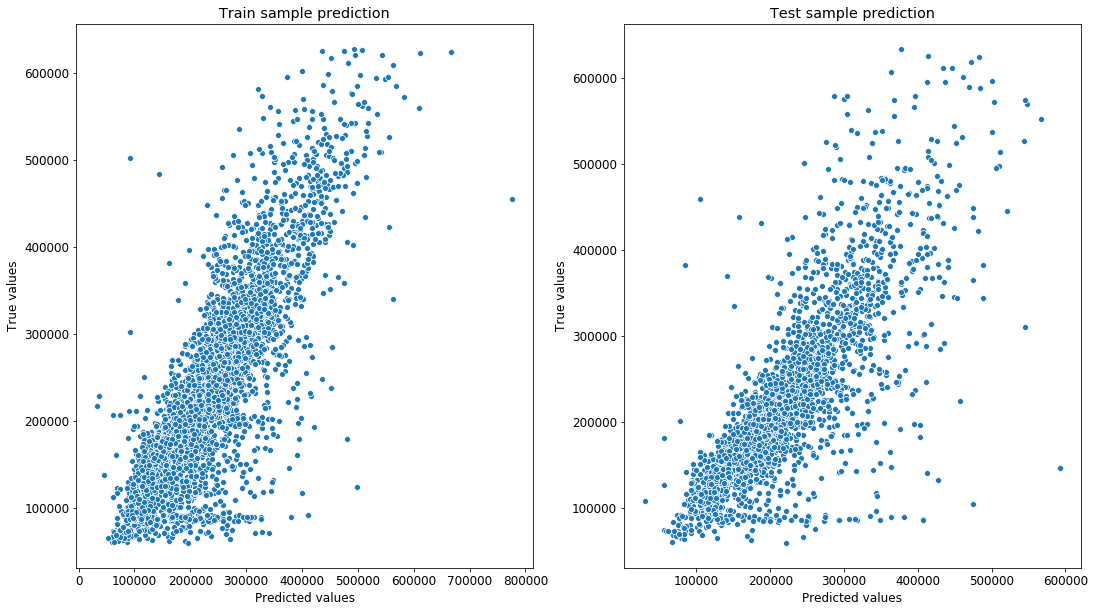

In [92]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 6.2 GradientBoostingRegressor

In [93]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025,
                                     random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.025, loss='huber', max_depth=6,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2250,
             presort='auto', random_state=21, subsample=1.0, verbose=0,
             warm_start=False)

Train R2:	0.881
Test R2:	0.744


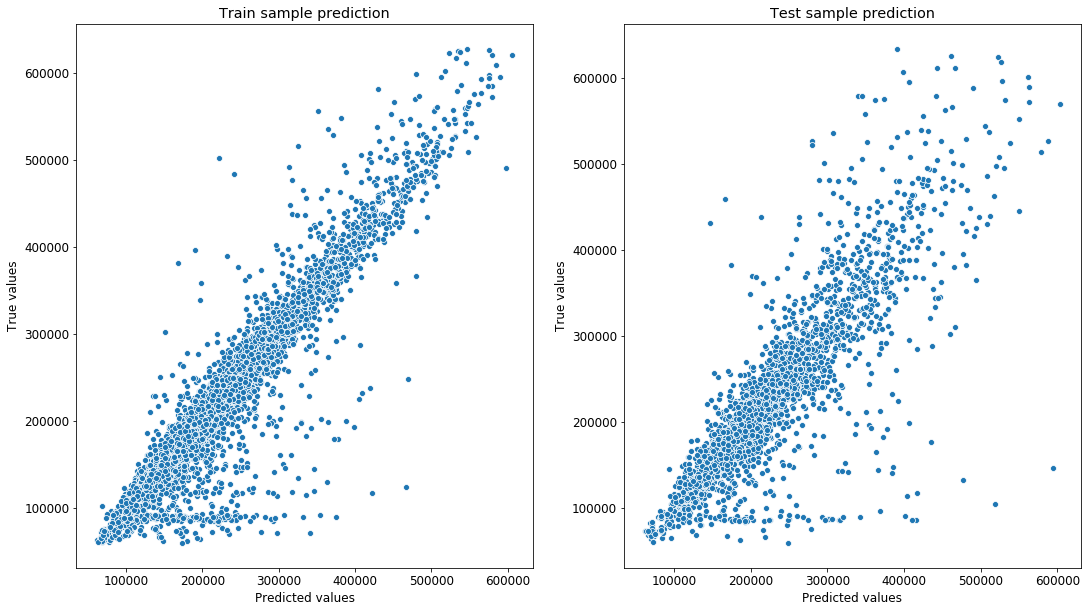

In [94]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 6.3 Кросс-валидация

In [95]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.79186445, 0.74568445, 0.7757477 ])

In [96]:
cv_score.mean()

0.7710988648671154

In [97]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

TypeError: data argument can't be an iterator

# Тестовый датасет

In [98]:
test_df.shape

(5000, 26)

In [99]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,PriceByDistrict
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,76.0,0,0,171145.169069,187994.569560,4577.817080
1,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,164.0,0,1,131107.271962,175771.383549,2633.806491
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,1,580.0,0,1,165993.292450,174137.278013,2754.698088
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,372.0,0,1,172778.615365,181626.175103,2323.276814
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,0,0,0,1,65.0,0,0,164116.183543,191145.790702,3384.759740
5,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,1,1,...,0,0,0,0,26.0,0,0,425037.641820,167338.787737,4709.143348
6,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,1,1,...,0,0,0,0,164.0,0,1,131107.271962,175771.383549,2633.806491
7,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,1,1,...,0,0,0,0,58.0,0,0,212894.088951,187994.569560,4550.709250
8,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,1,1,...,0,0,0,0,445.0,0,1,147956.025735,180270.303005,3228.679387
9,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,1,1,...,0,0,0,0,164.0,0,1,180750.471749,206782.391302,2633.806491


In [100]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


Лучшей моделью оказался GradientBoostingRegressor. На ней и обучаем нашу выборку

In [101]:
predictions = gb_model.predict(test_df)
predictions

array([171472.98974564, 130075.8381893 , 135141.20687354, ...,
       155538.14910031, 193996.62497018, 241748.37612368])

In [102]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,171472.989746
1,5925,130075.838189
2,960,135141.206874
3,3848,109618.062143
4,746,175149.370232


In [103]:
submit.to_csv('submit_final.csv', index=False)